In [1]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

n_digits: 10, 	 n_samples 1797, 	 n_features 64
__________________________________________________________________________________
init		time	inertia	silhouette
k-means++	0.15s	69432	0.144
random   	0.08s	69694	0.145
PCA-based	0.02s	70791	0.139
__________________________________________________________________________________


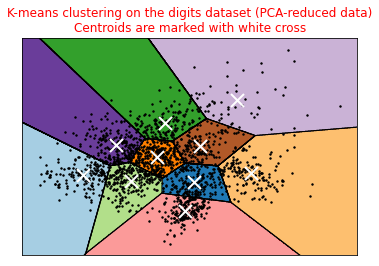

In [2]:
np.random.seed(42)

record = load_digits()
X_digits, y_digits = record.data, record.target
standardScalar = StandardScaler()
data = standardScalar.fit_transform(X_digits)  # 均值方差归一化

n_samples, n_features = data.shape
n_digits = len(np.unique(y_digits))  # 数字种类数量
labels = y_digits
print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))

print(82 * '_')
print('init\t\ttime\tinertia\tsilhouette')


def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f'
          % (name, (time() - t0),
             estimator.inertia_,  # Sum of squared distances of samples to their closest cluster center.
             metrics.silhouette_score(data, estimator.predict(data), metric='euclidean')))  # 轮廓系数


bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=data)

pca = PCA(n_components=n_digits).fit(data)
# in this case the seeding of the centers is deterministic, hence we run the kmeans algorithm only once with n_init=1
bench_k_means(KMeans(init=pca.components_,  # 使用pca特征向量作为初始聚类中心
                     n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=data)

print(82 * '_')

reduced_data = PCA(n_components=2).fit_transform(data)  # 选择2个主成分
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(1)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, levels=11)
plt.contour(xx, yy, Z, colors='black', linewidths=1, levels=11)  # 绘制聚类边界

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], s=2, color='black')  # 绘制降维后的散点图

centroids = kmeans.cluster_centers_  # 聚类中心
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, lw=2,
            color='w')  # 绘制聚类中心

plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross', color='r')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()